# Intro stuff

In [ ]:
%pip install boto3

In [ ]:
import boto3
import json
import requests

with open('keys.json') as f:
    keys = json.load(f)

dataset_link = 'https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD&api_foundry=true'

# URL of the CSV file
url = dataset_link

# S3 bucket and object key where you want to store the file
bucket_name = 'my-tf-test-bucket-meow-meow-meow'
object_key = 'nyc.csv'

# Download the file from the URL and upload it to S3
s3 = boto3.client('s3', aws_access_key_id = keys['access_key'], aws_secret_access_key = keys['secret_key'])
response = s3.put_object(Bucket=bucket_name, Key=object_key, Body=requests.get(url, stream=True).content)

if response['ResponseMetadata']['HTTPStatusCode'] == 200:
    print(f"File '{object_key}' uploaded successfully to '{bucket_name}' bucket.")
else:
    print(f"Failed to upload file '{object_key}' to '{bucket_name}' bucket.")


In [ ]:
url = s3.generate_presigned_url(
    ClientMethod='get_object',
    Params={
        'Bucket': bucket_name,
        'Key': object_key
    }
)

# Transforming part

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv(url)

In [ ]:
df.info()

In [ ]:
df.memory_usage()

In [ ]:
df.head()

In [ ]:
# Minimizing size of numeric columns

In [ ]:
df['CRASH DATETIME'] = df['CRASH DATE'] + ' ' + df['CRASH TIME']

In [ ]:
df['CRASH DATETIME'] = pd.to_datetime(df['CRASH DATETIME'])

In [ ]:
df = df.drop(['CRASH DATE', 'CRASH TIME', 'LOCATION'], axis=1) # location is too useless

In [ ]:
new_order = ['CRASH DATETIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'ON STREET NAME',
       'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']
df = df[new_order]

In [ ]:
import numpy as np

In [ ]:
df['ZIP CODE'] = df['ZIP CODE'].replace('     ', np.nan)

In [ ]:
df['ZIP CODE'] = df['ZIP CODE'].astype('float32')

In [ ]:
df['ZIP CODE'] = df['ZIP CODE'].astype('Int32')

In [ ]:
df['NUMBER OF PERSONS INJURED'] = df['NUMBER OF PERSONS INJURED'].astype('Int64')

In [ ]:
print(df['NUMBER OF PERSONS INJURED'].min(),
  df['NUMBER OF PERSONS INJURED'].max()
)

In [ ]:
df['NUMBER OF PERSONS INJURED'] = df['NUMBER OF PERSONS INJURED'].astype('Int8')

In [ ]:
df['NUMBER OF PERSONS KILLED'] = df['NUMBER OF PERSONS KILLED'].astype('Int64')

In [ ]:
print(df['NUMBER OF PERSONS KILLED'].min(),
  df['NUMBER OF PERSONS KILLED'].max()
)

In [ ]:
df['NUMBER OF PERSONS KILLED'] = df['NUMBER OF PERSONS KILLED'].astype('Int8')

In [ ]:
print(df['NUMBER OF PEDESTRIANS INJURED'].min(),
  df['NUMBER OF PEDESTRIANS INJURED'].max()
)

In [ ]:
df['NUMBER OF PEDESTRIANS INJURED'] = df['NUMBER OF PEDESTRIANS INJURED'].astype('int8')

In [ ]:
print(df['NUMBER OF PEDESTRIANS KILLED'].min(),
  df['NUMBER OF PEDESTRIANS KILLED'].max()
)

In [ ]:
df['NUMBER OF PEDESTRIANS KILLED'] = df['NUMBER OF PEDESTRIANS KILLED'].astype('int8')

In [ ]:
print(df['NUMBER OF CYCLIST INJURED'].min(),
  df['NUMBER OF CYCLIST INJURED'].max()
)

In [ ]:
df['NUMBER OF CYCLIST INJURED'] = df['NUMBER OF CYCLIST INJURED'].astype('int8')

In [ ]:
print(df['NUMBER OF CYCLIST KILLED'].min(),
  df['NUMBER OF CYCLIST KILLED'].max()
)

In [ ]:
df['NUMBER OF CYCLIST KILLED'] = df['NUMBER OF CYCLIST KILLED'].astype('int8')

In [ ]:
print(df['NUMBER OF MOTORIST INJURED'].min(),
  df['NUMBER OF MOTORIST INJURED'].max()
)

In [ ]:
df['NUMBER OF MOTORIST INJURED'] = df['NUMBER OF MOTORIST INJURED'].astype('int8')

In [ ]:
print(df['NUMBER OF MOTORIST KILLED'].min(),
      df['NUMBER OF MOTORIST KILLED'].max()
)

In [ ]:
df['NUMBER OF MOTORIST KILLED'] = df['NUMBER OF MOTORIST KILLED'].astype('int8')

In [ ]:
df['COLLISION_ID'] = df['COLLISION_ID'].astype('int32')

In [ ]:
df.info()

# Creating the dimensions
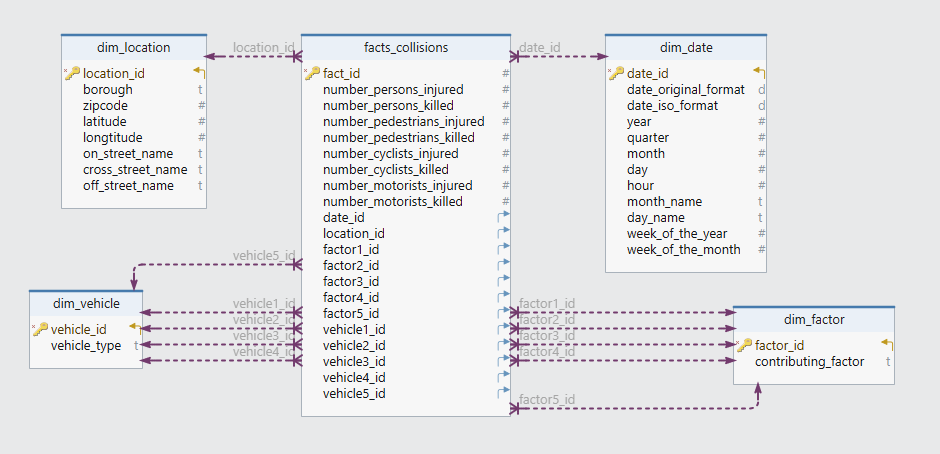

## Vehicle dimension

In [ ]:
vehicle_cols = ['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']
all_values = pd.concat([df[col] for col in vehicle_cols])
unique_values_list = all_values.dropna().unique().tolist()

In [ ]:
len(unique_values_list)

In [ ]:
len(set([w.lower() for w in unique_values_list]))

In [ ]:
# It looks like there are same values that are different because of uppercase use, I will lowercase every str column to get
# cleaner data

In [ ]:
str_columns = df.select_dtypes(include = 'object').columns.to_list()

In [ ]:
for col in str_columns:
  df[col] = df[col].str.lower()

In [ ]:
# Count the vehicle unique values again
vehicle_cols = ['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
                'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
                'VEHICLE TYPE CODE 5'
]
all_vehicle_values = pd.concat([df[col] for col in vehicle_cols])
unique_vehicle_values = all_vehicle_values.dropna().unique().tolist()
len(unique_vehicle_values)

In [ ]:
dim_vehicle = pd.DataFrame({
    'VEHICLE_ID': range(1, len(unique_vehicle_values) + 1),
    'VEHICLE_TYPE': unique_vehicle_values
})

dim_vehicle

## Factor Dimension

In [ ]:
factor_cols = ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
                'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
                'CONTRIBUTING FACTOR VEHICLE 5'
]
all_factor_values = pd.concat([df[col] for col in factor_cols])
unique_factor_values = all_factor_values.dropna().unique().tolist()

In [ ]:
unique_factor_values[:5]

In [ ]:
len(unique_factor_values)

In [ ]:
dim_factor = pd.DataFrame({
    'FACTOR_ID': range(1, len(unique_factor_values) + 1),
    'CONTRIBUTING_FACTOR': unique_factor_values
})

dim_factor.head()

## Data Dimension


In [ ]:
import calendar

def week_of_month(dt):
    year = dt.year
    month = dt.month
    day = dt.day

    cal = calendar.monthcalendar(year, month)
    week_number = (day - 1) // 7 + 1
    return week_number


start_date = df['CRASH DATETIME'].min()
end_date = df['CRASH DATETIME'].max()

dim_date = pd.DataFrame({'date': pd.date_range(start_date, end_date, freq='H')})
# Extract attributes
dim_date['YEAR'] = dim_date['date'].dt.year
dim_date['QUARTER'] = dim_date['date'].dt.quarter
dim_date['MONTH'] = dim_date['date'].dt.month
dim_date['MONTH_NAME'] = dim_date['date'].dt.strftime('%B')
dim_date['DAY'] = dim_date['date'].dt.day
dim_date['DAY_NAME'] = dim_date['date'].dt.strftime('%A')
dim_date['HOUR'] = dim_date['date'].dt.hour
dim_date['DATE_ISO_FORMAT'] = dim_date['date'].apply(lambda x: x.isoformat())
dim_date['DATE_ID'] = dim_date['date'].dt.strftime('%Y%m%d%H')
dim_date['WEEK_OF_THE_MONTH'] = dim_date['date'].apply(week_of_month)
dim_date['WEEK_OF_THE_YEAR'] = dim_date['date'].dt.strftime('%U')

In [ ]:
new_order = ['DATE_ID', 'DATE_ISO_FORMAT','YEAR','QUARTER','MONTH','DAY','HOUR','MONTH_NAME','DAY_NAME','WEEK_OF_THE_YEAR','WEEK_OF_THE_MONTH']
dim_date = dim_date[new_order]
dim_date

## Location dimension


In [ ]:
dim_location = df[['BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'ON STREET NAME',
    'CROSS STREET NAME', 'OFF STREET NAME']].drop_duplicates()

In [ ]:
dim_location['LOCATION_ID'] =  range(1, len(dim_location) + 1)

In [ ]:
dim_location = dim_location[['LOCATION_ID', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'ON STREET NAME',
    'CROSS STREET NAME', 'OFF STREET NAME']]

In [ ]:
dim_location = dim_location.rename(columns={
    'ZIP CODE': 'ZIPCODE',
    'ON STREET NAME': 'ON_STREET_NAME',
    'CROSS STREET NAME': 'CROSS_STREET_NAME',
    'OFF STREET NAME': 'OFF_STREET_NAME'
    })

In [ ]:
dim_location

# Fact Table

In [ ]:
df.columns

In [ ]:
df['DATE_ID'] = df['CRASH DATETIME'].dt.strftime('%Y%m%d%H')

In [ ]:
vehicle_map = dim_vehicle.set_index('VEHICLE_TYPE')['VEHICLE_ID'].to_dict()

In [ ]:
for col in vehicle_cols:
  df[col] = df[col].map(vehicle_map).astype('Int16')

In [ ]:
factor_map = dim_factor.set_index('CONTRIBUTING_FACTOR')['FACTOR_ID'].to_dict()

In [ ]:
for col in factor_cols:
  df[col] = df[col].map(factor_map).astype('Int8')

In [ ]:
df.iloc[:, 16:].head()


In [ ]:
fact_table = df.copy()

In [ ]:
fact_table = fact_table.rename(columns={
    'ZIP CODE': 'ZIPCODE',
    'ON STREET NAME': 'ON_STREET_NAME',
    'CROSS STREET NAME': 'CROSS_STREET_NAME',
    'OFF STREET NAME': 'OFF_STREET_NAME'
    })

In [ ]:
fact_table = fact_table.merge(dim_location, on=['BOROUGH', 'ZIPCODE', 'LATITUDE', 'LONGITUDE',
                                      'ON_STREET_NAME', 'CROSS_STREET_NAME', 'OFF_STREET_NAME'],
                                  how='left')

In [ ]:
fact_table['FACT_ID'] =  range(1, len(fact_table) + 1)

In [ ]:
fact_table = fact_table[['FACT_ID', 'DATE_ID','LOCATION_ID', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
                      'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
                      'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
                      'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
                      'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
                      'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']]

In [ ]:
fact_table = fact_table.rename(columns={
    'NUMBER OF PERSONS INJURED':'NUMBER_PERSONS_INJURED', 'NUMBER OF PERSONS KILLED':'NUMBER_PERSONS_KILLED',
    'NUMBER OF PEDESTRIANS INJURED':'NUMBER_PEDESTRIANS_INJURED', 'NUMBER OF PEDESTRIANS KILLED':'NUMBER_PEDESTRIANS_KILLED',
    'NUMBER OF CYCLIST INJURED':'NUMBER_CYCLISTS_INJURED', 'NUMBER OF CYCLIST KILLED':'NUMBER_CYCLISTS_KILLED',
    'NUMBER OF MOTORIST INJURED':'NUMBER_MOTORISTS_INJURED', 'NUMBER OF MOTORIST KILLED':'NUMBER_MOTORISTS_KILLED',
    'CONTRIBUTING FACTOR VEHICLE 1':'FACTOR1_ID', 'CONTRIBUTING FACTOR VEHICLE 2':'FACTOR2_ID', 'CONTRIBUTING FACTOR VEHICLE 3':'FACTOR3_ID',
    'CONTRIBUTING FACTOR VEHICLE 4':'FACTOR4_ID', 'CONTRIBUTING FACTOR VEHICLE 5':'FACTOR5_ID',
    'VEHICLE TYPE CODE 1':'VEHICLE1_ID', 'VEHICLE TYPE CODE 2':'VEHICLE2_ID', 'VEHICLE TYPE CODE 3':'VEHICLE3_ID',
    'VEHICLE TYPE CODE 4':'VEHICLE4_ID', 'VEHICLE TYPE CODE 5': 'VEHICLE5_ID'
})

In [ ]:
fact_table.head()

# Loading the data into snowflake

In [ ]:
%pip install sqlalchemy psycopg2-binary snowflake-sqlalchemy snowflake


In [ ]:
from sqlalchemy import create_engine
from snowflake.connector.pandas_tools import pd_writer


with open('snowflake.json') as f:
    snowflake_con = json.load(f)
    
# Create connection to Snowflake using your account and user
account_identifier = snowflake_con['account_identifier']
user = snowflake_con['user']
password = snowflake_con['password']
warehouse = snowflake_con['warehouse']
database = snowflake_con['database']
schema = snowflake_con['schema']

# Enhanced connection string including warehouse, database, and schema
conn_string = f"snowflake://{user}:{password}@{account_identifier}/{database}/{schema}?warehouse={warehouse}"

engine = create_engine(conn_string)
connection = engine.connect()

sql = "SELECT * FROM FACTS_COLLISIONS LIMIT 100"

try:
    connection.execute(sql)
finally:
    connection.close()
    engine.dispose()


In [ ]:
dim_vehicle.to_sql('DIM_VEHICLE', con=engine, index=False, if_exists='append', method=pd_writer)

# Close the engine
engine.dispose()

In [ ]:
dim_factor.to_sql('DIM_FACTOR', con=engine, index=False, if_exists='append', method=pd_writer)

# Close the engine
engine.dispose()

In [ ]:
dim_date.to_sql('DIM_DATE', con=engine, index=False, if_exists='append', method=pd_writer)

# Close the engine
engine.dispose()

In [ ]:
dim_location.to_sql('DIM_LOCATION', con=engine, index=False, if_exists='append', method=pd_writer)

# Close the engine
engine.dispose()

In [ ]:
fact_table.to_sql('FACTS_COLLISIONS', con=engine, index=False, if_exists='append', method=pd_writer)

# Close the engine
engine.dispose()